# **Determining a Driver's Inebriation Status using Regression Analysis**
Joseph Penovich - UID: 117210156<br>
CMSC320: Introduction to Data Science - Summer 2023<br>
Due August 20th, 2023

## Table of Contents
insert table of contents
## Introduction
### Background
The United States has one of the highest rates of deaths caused by vehicles accidents involving alcohol, which is difficult to attribute to any one factor. Arguments can be made about factors including the US's car dependent infrastructure, it's culture and stigma surrounding drinking alcohol and taking substances, local state and county traffic legislation, and more. One thing that can be agreed upon is that there is absolutely no reason or justification for driving while under the influence. It can be difficult for police to determine whether a traffic incident involves alcohol or other substances without conducting sobriety tests on those involved. 

This project seeks to identify factors that may indicate whether or not an accident involves an inebriated driver(s) using exploratory data analysis, and make predictions on a drivers inebriation tests using machine learning techniques such as logistic regression before police have the chance to conduct sobriety tests on involved individuals. 
### Data 
Montgomery County is Maryland's most populated county, and its residents come from a wide range of socioeconomic backgrounds. The data used in this project is a compiled list of traffic incidents involving collisions in Montgomery County from January 1st, 2015 to August 17th, 2023. This data was retrieved from the **U.S. Governments Public Open Data** site (`https://data.gov`) in addition to Montgomery County's Public Database, **Data Montgomery** (`https://data.montgomerycountymd.gov/`). The data includes factors such as Crash Date & Time, Injury Severity, Vehicle Damage Extent, Driver Substance Abuse, and more. 
***
## **Part 1: Data Collection, Parsing, and Management**
Let's get all the imports that we're going to use for this project, as well as our datasets.<br>
We'll be using two datasets provided by Data Montgomery, which are the datasets **"Crash Reporting - Drivers Data"**, which includes information of the driver(s) in an incident, and **"Crash Reporting - Incidents Data**, which includes general information about the incident itself. The dataset files for this project were downloaded into the directory rather than retrieved using queries. 

**Crash Reporting - Drivers Data:** `https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Drivers-Data/mmzv-x632`<br>
**Crash Reporting - Incidents Data:** `https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Incidents-Data/bhju-22kf`

In [166]:
# Necessary imports for data management, exploration, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [360]:
# Format dataset into Pandas Dataframe
driverData = pd.read_csv('moco_crash_data_drivers.csv', dtype={'Local Case Number':'str'})
incidentData = pd.read_csv('moco_crash_data_incidents.csv')
print(f"Driver shape: {driverData.shape}, Incident shape: {incidentData.shape}")

Driver shape: (164293, 43), Incident shape: (92987, 44)


In [ ]:
print(driverData.head(1000).to_string())

In [ ]:
print(incidentData.head(1000).to_string())

What we're curious about is what actually is the difference between the two datasets? We know that the drivers data includes more information about the driver, while the incidents data includes more general information, but what specifically so we know what to merge and what to drop?

In [361]:
# Get the variables for each data set
driversVars = np.array(driverData.columns)
incidentVars = np.array(incidentData.columns)

# Find the unique variable names in each
sharedVars = np.intersect1d(driversVars, incidentVars)
driversUniqueVars = np.setdiff1d(driversVars, sharedVars)
incidentUniqueVars = np.setdiff1d(incidentVars, sharedVars)
print(f"Shared Variables: {str(sharedVars)}")
print(f"Driver Data: {str(driversUniqueVars)}")
print(f"Incident Data: {str(incidentUniqueVars)}")

Shared Variables: ['ACRS Report Type' 'Agency Name' 'Collision Type' 'Crash Date/Time'
 'Cross-Street Name' 'Cross-Street Type' 'Driver Substance Abuse'
 'Latitude' 'Light' 'Local Case Number' 'Location' 'Longitude'
 'Municipality' 'Non-Motorist Substance Abuse' 'Off-Road Description'
 'Related Non-Motorist' 'Report Number' 'Road Name' 'Route Type'
 'Surface Condition' 'Traffic Control' 'Weather']
Driver Data: ['Circumstance' 'Driver At Fault' 'Driver Distracted By'
 'Driverless Vehicle' 'Drivers License State' 'Equipment Problems'
 'Injury Severity' 'Parked Vehicle' 'Person ID' 'Speed Limit'
 'Vehicle Body Type' 'Vehicle Continuing Dir' 'Vehicle Damage Extent'
 'Vehicle First Impact Location' 'Vehicle Going Dir' 'Vehicle ID'
 'Vehicle Make' 'Vehicle Model' 'Vehicle Movement'
 'Vehicle Second Impact Location' 'Vehicle Year']
Incident Data: ['At Fault' 'Direction' 'Distance' 'Distance Unit' 'First Harmful Event'
 'Fixed Oject Struck' 'Hit/Run' 'Intersection Area' 'Intersection Type'
 'J

Looking at the shared variables, there's important information that will help with the merge between the sets, like `Report Number` and `Driver Substance Abuse`. Each dataset has their own unique set of variables that's important to consider when performing our data analysis and regression. For example, the drivers data has information like `Injury Severity`, `Vehicle Damage Extent`, `Speed Limit`, `Vehicle Body Type`, and more. The incident data has information on `Hit/Run`, `First Harmful Event`, `Junctions`, and more which we will include. Some of the information between the two data sets have different column names, but the values are the same or similar like `Driver At Fault` in drivers data and `At Fault` in incidents data, 

So, what kind of information is important for regression analysis? Or more importantly, what information is not important and won't/can't be used, and that can be dropped from the datasets.<br>
**Unimportant Information:**
- `Local Case Number` ; There is already Report Number, which is more specific and suited to this projects purposes
- `Offroad Description`, Circumstance ; Descriptions are too specific to connect with other information
- `Vehicle Continuing Dir`, `Vehicle Going Dir` ; Direction of travel, but what angle the other vehicle was hit may be important
- `Location`, `Longitude`, and `Latitude` ; This project is not concerned with geographical data, since there is Municipality
- `Person ID` ; Not concerned with specific identities
- `Driverless Vehicle` ; Non applicable, driverless vehicles cannot drink and drive (that is known of)
- `Cross-Street Type`, `Cross-Street Name` ; Only concerned with single road name 
- `At Fault` ; There is already `Driver At Fault` in driver data
- `Mile Point`, `Mile Point Direction`, `Lane Direction`, `Lane Number`, `Distance Unit`<br>

Now let's get our merged data minus all unimportant information

In [375]:
# Make a list of all the vars to drop
unnecessary_vars = ['Local Case Number', 'Off-Road Description', 'Vehicle Continuing Dir', 
'Vehicle Going Dir', 'Location', 'Longitude', 'Latitude', 'Person ID',
'Driverless Vehicle', 'Cross-Street Type', 'Cross-Street Name', 'At Fault', 'Mile Point',
'Mile Point', 'Mile Point Direction', 'Lane Direction', 'Lane Number', 'Distance Unit']

# Merge using shared Variables to ensure no incidents with same report number but different attributes
data = pd.merge(driverData, incidentData, how='inner', on=list(sharedVars))
data.drop(columns=unnecessary_vars, inplace=True)
print(data.head(5).to_string())

  Report Number                Agency Name       ACRS Report Type         Crash Date/Time    Route Type     Road Name Municipality Related Non-Motorist     Collision Type Weather Surface Condition           Light Traffic Control Driver Substance Abuse Non-Motorist Substance Abuse Driver At Fault     Injury Severity Circumstance            Driver Distracted By Drivers License State                            Vehicle ID Vehicle Damage Extent Vehicle First Impact Location Vehicle Second Impact Location                                       Vehicle Body Type       Vehicle Movement  Speed Limit Parked Vehicle  Vehicle Year Vehicle Make Vehicle Model Equipment Problems Hit/Run Lane Type  Number of Lanes Direction  Distance Road Grade NonTraffic First Harmful Event Second Harmful Event Fixed Oject Struck              Junction      Intersection Type Intersection Area Road Alignment Road Condition                              Road Division
0   MCP3040003N   Montgomery County Police  Property Da

Now the data is more clean, only including the variables that we consider important. We can do some more cleaning of the data and aggregate some values.<br>

We'll add a new column that indicates whether the driver involved in the incident was under the influence 

In [376]:
# What tags indicate a driver not being under the influence
# Any other value means they were under the influence
notUnderInflTag = ['UNKNOWN', 'NONE DETECTED', np.nan]
data['underInfluence'] = ~data['Driver Substance Abuse'].isin(notUnderInflTag)
#print(data.head(30).to_string())

***
## **Part 2: Data Exploration and Analysis**
In this section we're going to be exploring some of the more significant factors that we suspect may help in predicting a drivers inebriation status. Since our data set includes 50+ different attributes for each incident, we won't be able to explore every single attribute. But we will look into some of the more meaningful attribute that we believe could be major factors in our regression analysis

### Road where Incident occurred
First let's find the roads with the most incidents, and see how many of those incidents were caused by drivers under the influence

Text(0.5, 1.0, 'Percentage of Total Vehicle Collisions involving Substances on Montgomery County Roads')

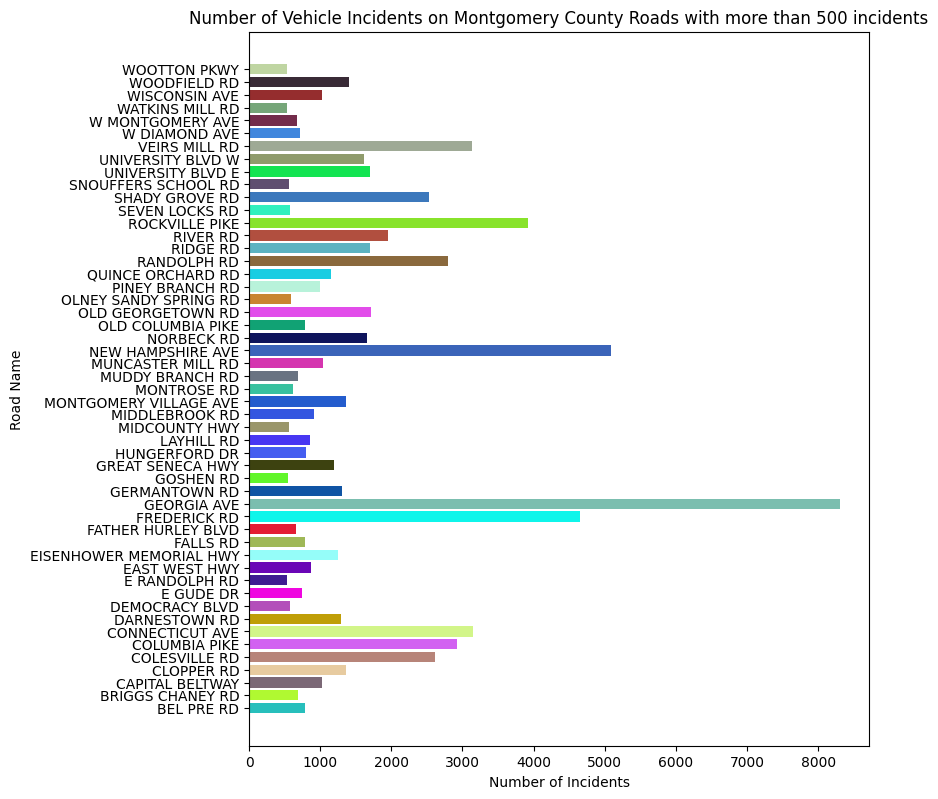

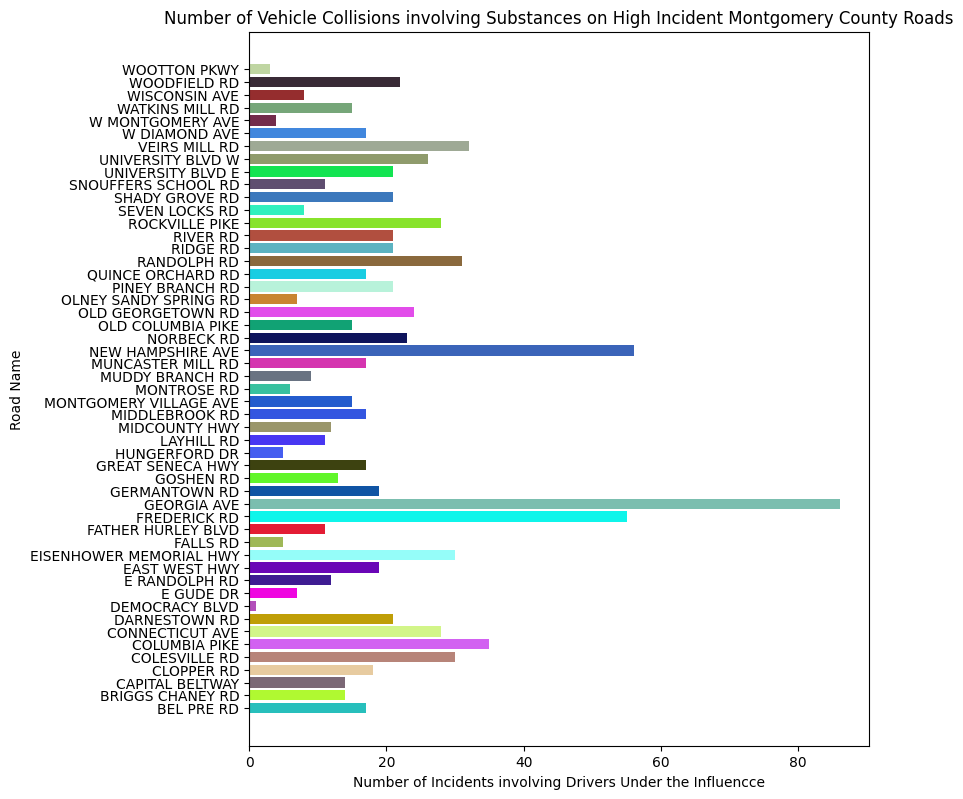

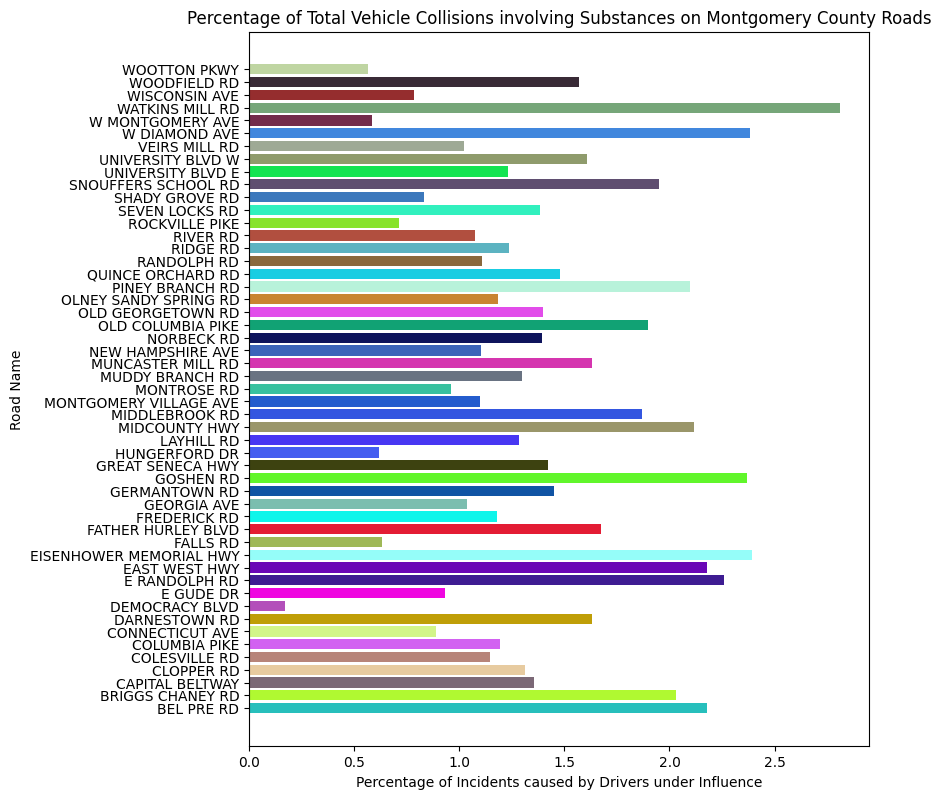

In [365]:
# Constant for name spacing in graphs 
bar_width_mod = 5.5
# Generate a list of n random colors
def nRandomColors(n):
    return list(tuple(np.random.random() for i in np.arange(3)) for j in np.arange(n))
# Find roads with at least inc_num incidents
# Minimum number of incidents
inc_num = 500
mostInc = data.value_counts(subset='Road Name', sort=False)
mostInc = mostInc[mostInc > inc_num]

# Plot data and format graph
plt.figure(figsize=(8, len(mostInc)/bar_width_mod))
colors = nRandomColors(len(mostInc))
plt.barh(y=mostInc.index, width=mostInc, color=colors)
plt.xlabel("Number of Incidents")
plt.ylabel("Road Name")
plt.title(f"Number of Vehicle Incidents on Montgomery County Roads with more than {inc_num} incidents")

# Determine how many events were under influence
influencedInc = data.value_counts(subset=['Road Name','underInfluence'], sort=False)
# Only use highest incident roads
influencedInc = influencedInc.loc[mostInc.index]
# Only count incidents of drunk driving
influencedInc = influencedInc.loc[:,True]

plt.figure(figsize=(8, len(influencedInc)/bar_width_mod))
plt.barh(y=influencedInc.index, width=influencedInc, color=colors)
plt.xlabel("Number of Incidents involving Drivers Under the Influencce")
plt.ylabel("Road Name")
plt.title(f"Number of Vehicle Collisions involving Substances on High Incident Montgomery County Roads")

# Now make a plot of percentage of the incidents involving substances
plt.figure(figsize=(8, len(influencedInc)/bar_width_mod))
plt.barh(y=mostInc.index, width=100*(influencedInc/mostInc), color=colors)
plt.xlabel("Percentage of Incidents caused by Drivers under Influence")
plt.ylabel("Road Name")
plt.title(f"Percentage of Total Vehicle Collisions involving Substances on Montgomery County Roads")

Now we can see a few different factors here. We see that Georgia Avenue has by far the most incidents, both total incidents and ones involving drivers under the influence. However, we can see that the percentage of influenced drivers on ***Georgia Avenue*** is actually relatively low compared to the percentages of incidents on other roads. We see that the percentage of incidents involving a driver under the influence for roads like ***Goshen Road***, ***Eisenhower Memorial Highway***, ***West Mongomery Avenue***, and ***Watkins Mill Road*** are much higher. This means that the rate of drunk drivers is different based on which road the incident occurs on, which means that the road the incident occurs on is a significant factor when determining if a driver involved in the incident is under the influence.<br>

### Time of Incident
It's important to look at other factors that may be significant in prediction too, one of these factors being the time of the incident. There may be certain periods of time where incidents involving influenced drivers are more common. We'll try to predict times that will have a higher rate of it being caused by drivers under the influence<br>

> **Hypothesis**: *Incidences that occur between the times of* **`23:00`** *and* **`3:00`** *are more likely involve drivers under the influence*<br>

Using the exact time of the incident would be too specific, grouping the incidents into periods of time would offer better results. Thirty minute periods is likely the best choice since it will divide the data into 48 groups, which will be plotted against number of incidents involving influenced drivers, and percentage of all incidents during those time periods involving influenced drivers.

In [377]:
# Create a column called 'timeGroup' which stores 30 minute time intervals
data['timeGroup'] = pd.to_datetime(data['Crash Date/Time']).dt.time
data['timeGroup'] = data['timeGroup'].apply(lambda x: str(dt.time(x.hour,30*int(x.minute/30),0)))
#print(data.head(30).to_string())

/var/folders/jz/1t01vq454mb7mgplm4k2_x6r0000gn/T/ipykernel_67984/485003469.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['timeGroup'] = pd.to_datetime(data['Crash Date/Time']).dt.time


Text(0.5, 1.0, 'Vehicle Incidents on Montgomery County Roads grouped by Time')

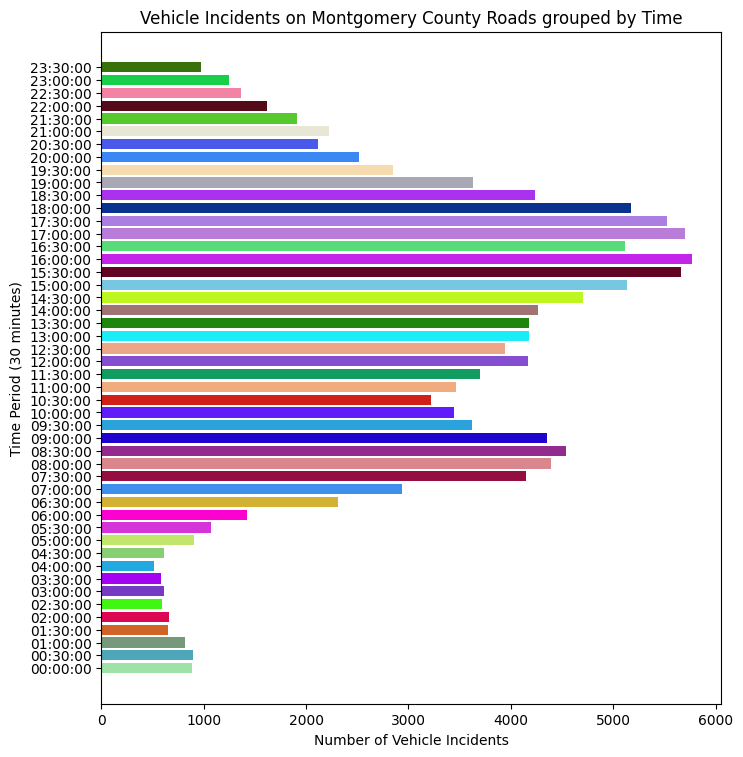

In [367]:
# Organize frequency of arguments by time
incidentsByTime = data.value_counts(subset='timeGroup', sort=False, ascending=True)
# Plot incidents by time group
colors=nRandomColors(len(incidentsByTime))
plt.figure(figsize=(8, len(incidentsByTime)/bar_width_mod))
plt.barh(y=incidentsByTime.index,width=incidentsByTime,color=colors)
plt.xlabel("Number of Vehicle Incidents")
plt.ylabel("Time Period (30 minutes)")
plt.title("Vehicle Incidents on Montgomery County Roads grouped by Time")

From the graph, the trend on when the most accidents happen becomes clear. Peak traffic hours, aka rush hour, which is around 7:00 am to 9:30 am and 3:00 to 7:00 are when the most accidents happen. But that's not the information that we're seeking, we want to know more about when most accidents involving drivers under the influence happen

Text(0.5, 1.0, 'Vehicle Incidents involving Influenced Drivers on Montgomery County Roads grouped by Time')

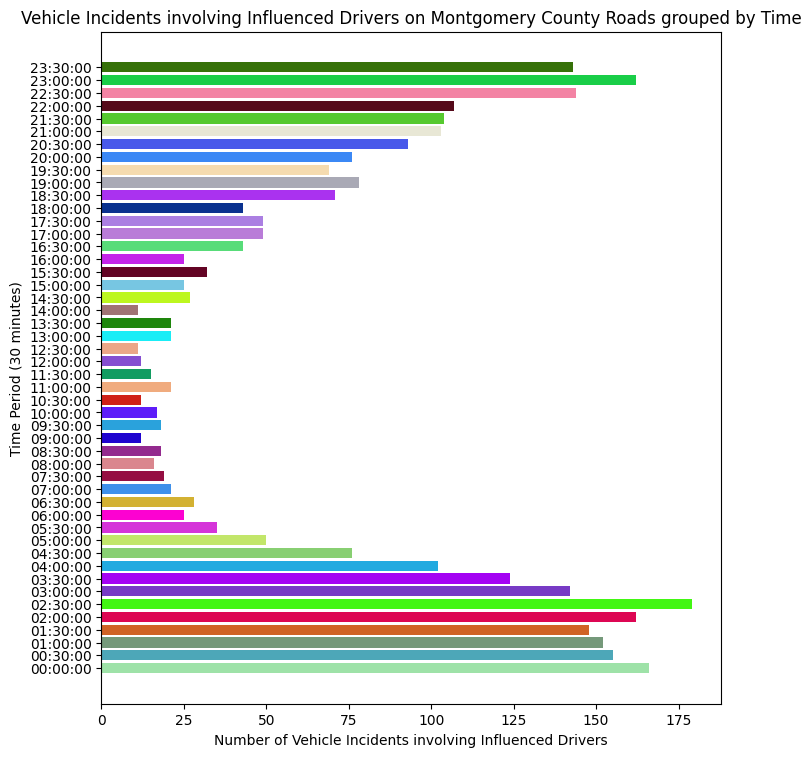

In [368]:
# Organize by frequency of accidents by time period and group by under the influence
inflIncByTime = data.value_counts(subset=['timeGroup','underInfluence'], sort=False)
inflIncByTime = inflIncByTime[:,True]
# Plot incidents involving influenced drivers by time group
plt.figure(figsize=(8, len(inflIncByTime)/bar_width_mod))
plt.barh(y=inflIncByTime.index,width=inflIncByTime,color=colors)
plt.xlabel("Number of Vehicle Incidents involving Influenced Drivers")
plt.ylabel("Time Period (30 minutes)")
plt.title("Vehicle Incidents involving Influenced Drivers on Montgomery County Roads grouped by Time")

Looks like our **hypothesis was correct**, the time period with the highest number of influenced driving incidents is 2:30 am, and the most incidents seem to happen between our time interval of 11:00 pm to 3:00 am. We can find the proportion of these incidents as well:

In [369]:
# Cast to np array
infl_inc_np = np.array(inflIncByTime)
print(f"{100*(infl_inc_np[-2:].sum()+infl_inc_np[:6].sum())/infl_inc_np.sum()}% of all influenced "
      + "driving incidents occur between 11:00 pm and 3:00 am")

39.20173267326733% of all influenced driving incidents occur between 11:00 pm and 3:00 am


Roughly 40% of all incidents involving an influenced driver the hours of `23:00` and `3:00` despite only making up 1/6 of the total day. Let's make a graph that illustrates the percentage of incidents that are caused by drunk drivers at each time period.

Text(0.5, 1.0, 'Percentage of Vehicle Incidents caused by Drivers under the Influence at different Time Intervals')

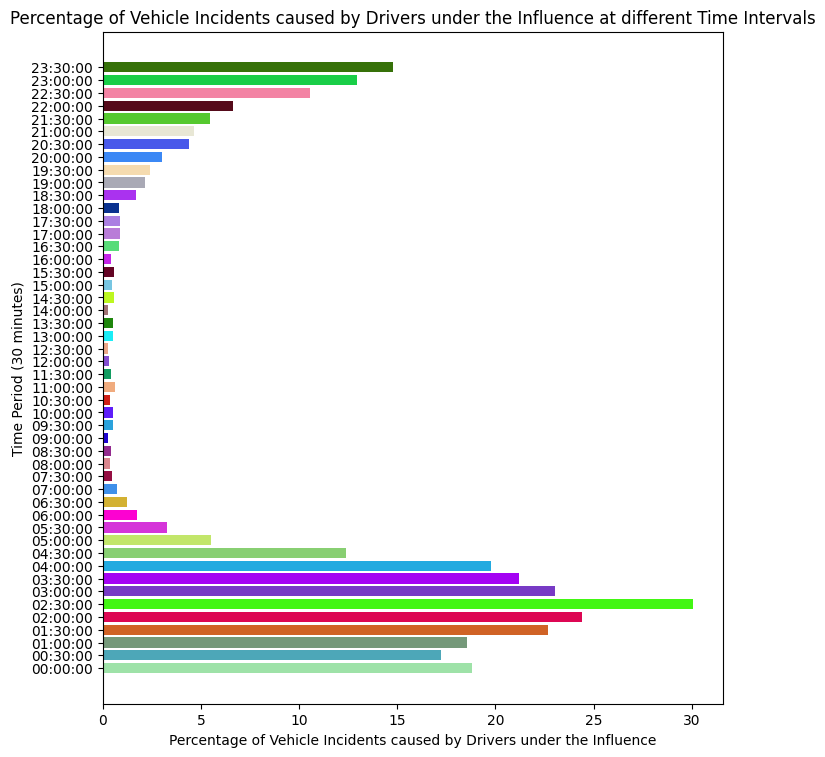

In [370]:
# Plot percentage of incidents caused by drivers under the influence at each time period
plt.figure(figsize=(8, len(inflIncByTime)/bar_width_mod))
plt.barh(y=inflIncByTime.index,width=100*inflIncByTime/incidentsByTime,color=colors)
plt.xlabel("Percentage of Vehicle Incidents caused by Drivers under the Influence")
plt.ylabel("Time Period (30 minutes)")
plt.title("Percentage of Vehicle Incidents caused by Drivers under the Influence at different Time Intervals")

This graph illustrates a major point of information on predicting if an incident involved a driver under the influence. Nearly 30% of all accidents that occur between 2:30 and 3:00 am are associated with a driver under the influence. For the hours of 1:30 am to 2:30 am and 3:00 am to 4:30 am, if an incident occurs there is more than a 20% chance that it includes an influenced driver. This is a significant factor when it comes to our regression model predicting if a driver is inebriated, which we will include as a key variable for our machine learning. The next factor we'll look at may be a little more subtle 

### Involved Vehicle Make and Year
One might think that make and year of the car might not really have anything to do with vehicle accidents. But on the contrary, as vehicles advance techonlogically and safety measures improve, it could prove to show that more recent years of cars, as well as more expensive brands might be involved in less accidents
> **Hypothesis:** More recent car years and more expensive brand models are involved in less accidents, both involving drivers under the influence or not<br>

This may help with regression, as if there is a correlation between year and make of the car, and incident prevelance, this could be a good attribute to add to our model

What range of years and makes are included in this data set?

In [371]:
# Print the different makes and years that appear in the data set
print(pd.Series(data['Vehicle Make'].unique()).head(20))
print(data['Vehicle Year'].unique())

0          HONDA
1            UNK
2           FORD
3           TOYT
4       KENWORTH
5     VOLKSWAGEN
6           HYUN
7          MAZDA
8            GMC
9            BMW
10           KIA
11          GILL
12         CHEVY
13          SUBA
14          VOLK
15          HOND
16        TOYOTA
17       HYUNDAI
18          PORS
19    VOLKSWAGON
dtype: object
[2004    0 2003 2016 2001 2006 2014 2009 2000 2023 2005 2011 2019 2017
 2008 2013 2022 2012 2020 2015 2018 2007 2010 2021 1996 1999 1998 1997
 1991 2002 1995 9999 1992 2024 1900 1994 1985 1990   99 1993 1986 2101
 1988  201 1976 1989 1987 1008 2033 1977    3 1961 1980 2998 1978 1111
 1966 1967 3003 1015 1975 1979  200 1982  202 1984 2040 2996 2208 2917
  215 1965 2103 2916 1901 1968 1972   13    8 1963 1969 1983 1970 1960
 2991    1 1949 2105 1959 2997   97 1005 2914 2911 2099 1974 3013 1014
 1971 5005 1140 2201 2919 1981 2041 2200 7817 2912 2100    4 2048 2104
   14  198 1955 8008 3863    2 2204 1012 2055 2102  999   15 1025 1234
 8888]


Unfortunately it seems that there is a lot of human error when these reports were made. There are many abbreviations and typos for the make of car in the dataset. Examples include '*HOND*' instead of '*HONDA*', '*CHEVEROLET*' instead of '*CHEVROLET*', '*TOYT*' instead of '*TOYOTA*', and many more. Furthermore, there are also many incorrect years listed in the reports, such as the years 1, 2, 3, 4, 999, 1234, 2048, 2911, 8008, 9999.

To fix this, we're going to perform some more data cleaning and curation. We  will view the most frequently reported vehicle makes and map any abbreviations or misspellings to its full actual name (like '*HOND*' to '*HONDA*'). For the incorrect years, we will replace any vehicle year that is unreasonable with NaN

In [378]:
# Clean vehicle year year
lowerYear, upperYear = 1900, 2023
data['Vehicle Year'] = data['Vehicle Year'].apply(lambda x: np.nan if x < lowerYear or x > upperYear else x)

# Acquire the most frequent vehicle models in the data
incidentsByMake = data.value_counts(subset=['Vehicle Make'])
incidentsByMake = incidentsByMake[incidentsByMake > 250]
# Map abbreviations/typos to actual model name
vehicleMakeMapping = {"ACUR":"ACURA", "CADI":"CADILLAC","CHEV":"CHEVROLET", "CHEVY":"CHEVROLET",
"CHRY":"CHRYSLER","DODG":"DODGE", "FRHT":"FREIGHTLINER", "HOND":"HONDA", "HYUN":"HYUNDAI",
"INFI":"INFINITI", "LEXS":"LEXUS", "LEXU":"LEXUS", "MAZD":"MAZDA", "MITS":"MITSUBISHI",
"MERZ":"MERCEDES", "NISS":"NISSAN", "SUBA":"SUBARU", "THOM":"THOMAS","TOYT":"TOYOTA", 
"VOLK":"VOLKSWAGON", "VOLKS":"VOLKSWAGON", "VOLV":"VOLVO", "VW":"VOLKSWAGON"}
# Apply dictionary
def applyMapping(x):
    try:
        return vehicleMakeMapping[x]
    except KeyError:
        return x
data['Vehicle Make'] = data['Vehicle Make'].apply(lambda x: applyMapping(x))
incidentsByMake = data.value_counts(subset=['Vehicle Make'])
incidentsByMake = incidentsByMake[incidentsByMake > 250]
print(pd.Series(incidentsByMake).to_string())

  Report Number                Agency Name       ACRS Report Type         Crash Date/Time        Route Type       Road Name Municipality Related Non-Motorist           Collision Type  Weather Surface Condition           Light Traffic Control Driver Substance Abuse Non-Motorist Substance Abuse Driver At Fault     Injury Severity Circumstance            Driver Distracted By Drivers License State                            Vehicle ID Vehicle Damage Extent Vehicle First Impact Location Vehicle Second Impact Location                                       Vehicle Body Type         Vehicle Movement  Speed Limit Parked Vehicle  Vehicle Year Vehicle Make Vehicle Model Equipment Problems Hit/Run Lane Type  Number of Lanes Direction  Distance Road Grade NonTraffic First Harmful Event Second Harmful Event Fixed Oject Struck              Junction      Intersection Type Intersection Area Road Alignment Road Condition                              Road Division  underInfluence timeGroup
0   MCP3040003